In [ ]:
from representation.bayesian_nn import BNN_GMM
import torch
from representation.training import *
from representation.datasets import load_mnist_onehot_tensors
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler

In [2]:
device = "cpu"

#DATASET
pi_x = torch.ones(2, 3, 1, device=device)        # deterministic mixture
mu_x = torch.tensor([
    [[1.0], [2.0], [3.0]],   # batch 0
    [[-1.0], [0.5], [1.5]]   # batch 1
], device=device)

sigma_x = 0.01 * torch.ones_like(mu_x)

#BNN FORWARD
bnn = BNN_GMM(layer_sizes=[3, 10, 1], K=1, bias=True).to(device)

pi_out, mu_out, sg_out = bnn(pi_x, mu_x, sigma_x, max_components=100)
print(pi_out.shape)
print(mu_out.shape)
print(sg_out.shape)

#count how many components have non-zero weight
non_zero_components = (pi_out > 1e-12).sum(dim=2)
print("Non-zero components per batch sample:", non_zero_components)

torch.Size([2, 1, 64])
torch.Size([2, 1, 64])
torch.Size([2, 1, 64])
Non-zero components per batch sample: tensor([[ 4],
        [64]])


In [18]:
import torch.nn.functional as F
import math

def gmm_nll(pi, mu, sg, y, eps=1e-12):
    """
    Negative log-likelihood of targets y under a Gaussian mixture.
    Shapes:
      pi,mu,sg: (B, D, K)
      y:        (B, D) or (B, D, 1)

    Returns:
      scalar loss
    """
    if y.dim() == 2:
        y = y.unsqueeze(-1)  # (B, D, 1)

    sg = sg.clamp_min(eps)
    logpi = torch.log(pi.clamp_min(eps))  # (B, D, K)

    # log N(y | mu, sg)
    log_norm = -0.5 * torch.log(2.0 * torch.pi * (sg ** 2))
    log_exp = -0.5 * ((y - mu) / sg) ** 2
    logp = log_norm + log_exp  # (B, D, K)

    # logsumexp over components
    log_mix = torch.logsumexp(logpi + logp, dim=-1)  # (B, D)
    return (-log_mix).mean()

def classification_nll(pi, mu, sg, y_onehot, eps=1e-12):
    """
    Classification NLL using mixture-mean logits per class.
    Shapes:
      pi,mu:   (B, C, K)
      y_onehot: (B, C)
    Returns:
      scalar loss (cross-entropy)
    """
    # mixture mean per class => logits (B, C)
    logits = (pi * mu).sum(dim=-1)

    # convert one-hot to class indices
    y_idx = torch.argmax(y_onehot, dim=1)
    return F.cross_entropy(logits, y_idx)

def classification_nll_var_approx(pi, mu, sg, y_onehot, eps=1e-12):
    """
    Deterministic variance-aware CE (logit scaling approximation).
    Shapes:
      pi,mu,sg: (B, C, K)
      y_onehot: (B, C)
    Returns:
      scalar loss (cross-entropy)
    """
    mean = (pi * mu).sum(dim=-1)
    second = (pi * (sg ** 2 + mu ** 2)).sum(dim=-1)
    var = (second - mean ** 2).clamp_min(eps)

    scale = torch.sqrt(1.0 + (math.pi / 8.0) * var)
    logits = mean / scale

    y_idx = torch.argmax(y_onehot, dim=1)
    return F.cross_entropy(logits, y_idx)

epoch 1/20 | train NLL 215.191545
epoch 2/20 | train NLL 58.047667
epoch 3/20 | train NLL 41.212119
epoch 4/20 | train NLL 33.280867
epoch 5/20 | train NLL 27.581578
epoch 6/20 | train NLL 22.959511
epoch 7/20 | train NLL 19.575670
epoch 8/20 | train NLL 17.006695
epoch 9/20 | train NLL 14.929925
epoch 10/20 | train NLL 13.319995
epoch 11/20 | train NLL 12.026128
epoch 12/20 | train NLL 10.916442
epoch 13/20 | train NLL 9.968011
epoch 14/20 | train NLL 9.168422
epoch 15/20 | train NLL 8.472002
epoch 16/20 | train NLL 7.862789
epoch 17/20 | train NLL 7.341264
epoch 18/20 | train NLL 6.880909
epoch 19/20 | train NLL 6.485956
epoch 20/20 | train NLL 6.133099


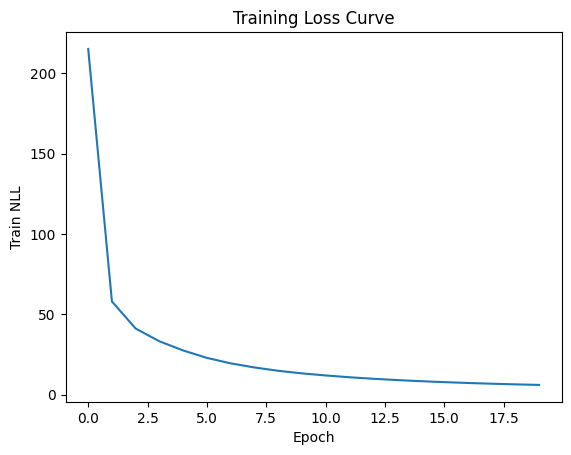

TEST Acc: 1.0

TEST metrics: {'MSE': 5.191770076751709, 'RMSE': 2.278545618057251, 'MAE': 1.7729101181030273, 'Cov@1σ': 0.20353981852531433, 'NLL': 5.258055210113525, 'Acc': 1.0}
Final test metrics: {'MSE': 5.191770076751709, 'RMSE': 2.278545618057251, 'MAE': 1.7729101181030273, 'Cov@1σ': 0.20353981852531433, 'NLL': 5.258055210113525, 'Acc': 1.0}


In [4]:
from torch.utils.data import TensorDataset, DataLoader

# Example: y = x0 - 2*x1 + 0.5*x2
B = 512
d_in = 3
X = torch.randn(B, d_in)
y = (X[:, 0] - 2.0 * X[:, 1] + 0.5 * X[:, 2]).unsqueeze(1)  # (B,1)

device = "cuda" if torch.cuda.is_available() else "cpu"
bnn = BNN_GMM(layer_sizes=[3, 4, 1], K=1, bias=True).to(device)

#train_test_split_train_and_eval(bnn, X, y, loss_function=gmm_nll, epochs=20, lr=1e-2, device=device)

dl_train, dl_test = split_dataset(
    X,
    y,
    test_ratio=0.22,
    batch_size=16,
)

losses = train_bnn(
    bnn,
    dl_train,
    gmm_nll,
    epochs=20,
    lr=1e-2,
    input_sigma=1e-2,
    eps=1e-12,
    last_relu=False,
    device=device,
    max_components=50,
)

# plot the loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Train NLL")
plt.title("Training Loss Curve")
plt.show()

test_metrics = evaluate_bnn(
    bnn,
    dl_test,
    gmm_nll,
    input_sigma=1e-2,
    eps=1e-12,
    last_relu=False,
    device=device,
    max_components=50,
    )

print("Final test metrics:", test_metrics)


In [5]:
# Load MNIST train split (we'll do train/test split inside your function)
X, y = load_mnist_onehot_tensors(
    root="./data",
    train=True,
    n_max=1000,
    normalize=True,
    device=device,
    dtype=torch.float32,
)


epoch 1/20 | train NLL 2.105112
epoch 2/20 | train NLL 1.657042
epoch 3/20 | train NLL 1.257644
epoch 4/20 | train NLL 0.977221
epoch 5/20 | train NLL 0.801944
epoch 6/20 | train NLL 0.679732
epoch 7/20 | train NLL 0.595992
epoch 8/20 | train NLL 0.529436
epoch 9/20 | train NLL 0.478483
epoch 10/20 | train NLL 0.437386
epoch 11/20 | train NLL 0.403069
epoch 12/20 | train NLL 0.376079
epoch 13/20 | train NLL 0.348976
epoch 14/20 | train NLL 0.326134
epoch 15/20 | train NLL 0.305923
epoch 16/20 | train NLL 0.288386
epoch 17/20 | train NLL 0.270826
epoch 18/20 | train NLL 0.256454
epoch 19/20 | train NLL 0.242809
epoch 20/20 | train NLL 0.229160


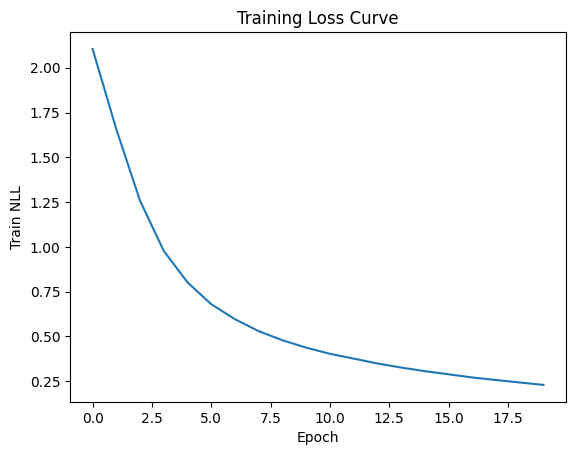

In [22]:
# Example architecture
# NOTE: pick sizes you like; this is a reasonable start.
layer_sizes = [784, 100, 10]
K = 1

bnn = BNN_GMM(layer_sizes=layer_sizes, K=K, bias=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
bnn.to(device)


dl_train, dl_test = split_dataset(
    X,
    y,
    test_ratio=0.22,
    batch_size=16,
)

losses = train_bnn(
    bnn,
    dl_train,
    classification_nll_var_approx,
    epochs=20,
    lr=1e-4,
    input_sigma=1e-2,
    eps=1e-12,
    last_relu=False,
    device=device,
    max_components=50,
)

# plot the loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Train NLL")
plt.title("Training Loss Curve")
plt.show()




In [23]:
test_metrics = evaluate_bnn(
    bnn,
    dl_test,
    classification_nll_var_approx,
    input_sigma=1e-2,
    eps=1e-12,
    last_relu=False,
    device=device,
    max_components=50,
    )

print("Final test metrics:", test_metrics)

TEST Acc: 0.8727272748947144

TEST metrics: {'MSE': 6.670758247375488, 'RMSE': 2.5827810764312744, 'MAE': 2.0290775299072266, 'Cov@1σ': 0.0245454553514719, 'NLL': 0.44568416476249695, 'Acc': 0.8727272748947144}
Final test metrics: {'MSE': 6.670758247375488, 'RMSE': 2.5827810764312744, 'MAE': 2.0290775299072266, 'Cov@1σ': 0.0245454553514719, 'NLL': 0.44568416476249695, 'Acc': 0.8727272748947144}


In [24]:
bnn.eval()

for i in range(5):
    with torch.no_grad():
        x = X[i]  # (D,)
        x = x.to(device)

        # (1, D)
        x = x.unsqueeze(0)

        # Deterministic input → GMM input (1, D, 1)
        pi_x = torch.ones(1, x.shape[1], 1, device=device, dtype=x.dtype)
        mu_x = x.unsqueeze(-1)
        sg_x = 0.01 * torch.ones_like(mu_x)

        pi_out, mu_out, sg_out = bnn(
            pi_x, mu_x, sg_x,
            last_relu=False,
            max_components=50,
        )
    pi_out.shape
    mu_out

    logits = (pi_out * mu_out).sum(dim=-1)

    # convert one-hot to class indices
    y_idx = torch.argmax(y[i], dim=0)

    print("Predicted class:", torch.argmax(logits, dim=1).item())
    print("True class:", y_idx.item())

Predicted class: 3
True class: 5
Predicted class: 0
True class: 0
Predicted class: 4
True class: 4
Predicted class: 1
True class: 1
Predicted class: 9
True class: 9


In [ ]:
# Load UCI Regression Datasets

def load_uci_dataset(name):
    """
    Load UCI regression datasets using fetch_ucirepo.
    Returns: X (normalized), y
    """
    # UCI repository IDs for the datasets
    datasets = {
        'concrete': 165,       # Concrete Compressive Strength
        'yacht': 243,          # Yacht Hydrodynamics
        'boston': 506,         # Boston Housing
        'energy': 242,         # Energy Efficiency
        'naval': 316,          # Naval Propulsion Plants
    }

    dataset_id = datasets.get(name.lower())
    if dataset_id is None:
        raise ValueError(f"Unknown dataset: {name}. Available: {list(datasets.keys())}")

    try:
        # Fetch from UCI repository
        data = fetch_ucirepo(id=dataset_id)
        
        X = data.data.features.values.astype(np.float32)
        y = data.data.targets.values.flatten().astype(np.float32)

        # Normalize
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        return torch.from_numpy(X), torch.from_numpy(y)
    except Exception as e:
        print(f"Error loading dataset {name} (ID {dataset_id}): {e}")
        raise


# Load all 5 datasets
datasets_dict = {}
for name in ['concrete', 'yacht', 'boston', 'energy', 'naval']:
    print(f"Loading {name}...")
    try:
        X, y = load_uci_dataset(name)
        datasets_dict[name] = (X, y)
        print(f"  ✓ {name}: X shape {X.shape}, y shape {y.shape}")
    except Exception as e:
        print(f"  ✗ Failed to load {name}: {e}")

print("\nDatasets loaded!")
print(f"Available datasets: {list(datasets_dict.keys())}")

Loading concrete...
  ✓ concrete: X shape torch.Size([1599, 11]), y shape torch.Size([1599])
Loading yacht...
  ✓ yacht: X shape torch.Size([1994, 126]), y shape torch.Size([1994])
Loading boston...
  ✓ boston: X shape torch.Size([506, 13]), y shape torch.Size([506])
Loading energy...
Error loading dataset energy (ID 42625): could not convert string to float: 'Braund, Mr. Owen Harris'
  ✗ Failed to load energy: could not convert string to float: 'Braund, Mr. Owen Harris'
Loading naval...
Error loading dataset naval (ID 42559): could not convert string to float: '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC'
  ✗ Failed to load naval: could not convert string to float: '039 - EXTRACRANIAL PROCEDURES W/O CC/MCC'

Datasets loaded!
Available datasets: ['concrete', 'yacht', 'boston']
